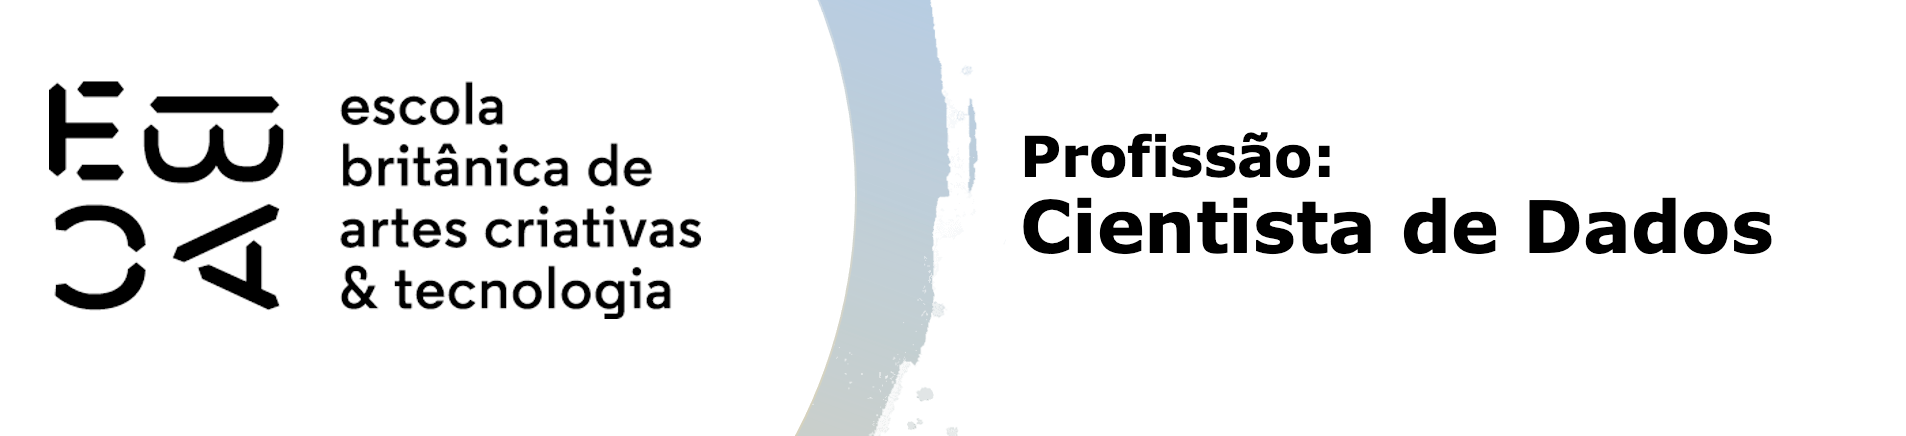

# Tarefa I

Neste projeto, estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

Carregue a base de dados ```credit_scoring.ftr```.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import statsmodels.formula.api as smf
import statsmodels.api as sm

from scipy.stats import t
from sklearn import metrics
from scipy.stats import ks_2samp
from sklearn.metrics import roc_curve
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler

import warnings

In [5]:
df = pd.read_feather('credit_scoring.ftr')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


## Amostragem

Separe os três últimos meses como safras de validação *out of time* (oot).

Variáveis:<br>
Considere que a variável ```data_ref``` não é uma variável explicativa, é somente uma variável indicadora da safra, e não deve ser utilizada na modelagem. A variávei ```index``` é um identificador do cliente, e também não deve ser utilizada como covariável (variável explicativa). As restantes podem ser utilizadas para prever a inadimplência, incluindo a renda.


In [6]:
df.set_index('data_ref', inplace=True)

df_train = df[: '2015-12-01']
df_test = df['2016-01-01':]

In [7]:
df.reset_index(inplace=True)
df_train.reset_index(inplace=True)
df_test.reset_index(inplace=True)

## Descritiva básica univariada

- Descreva a base quanto ao número de linhas, número de linhas para cada mês em ```data_ref```.
- Faça uma descritiva básica univariada de cada variável. Considere as naturezas diferentes: qualitativas e quantitativas.

In [8]:
df_train['mes'] = df_train['data_ref'].dt.month
df_test['mes'] = df_test['data_ref'].dt.month
warnings.filterwarnings('ignore')

C:\Users\Leo\AppData\Local\Temp\ipykernel_20284\2875380466.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['mes'] = df_train['data_ref'].dt.month
C:\Users\Leo\AppData\Local\Temp\ipykernel_20284\2875380466.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['mes'] = df_test['data_ref'].dt.month


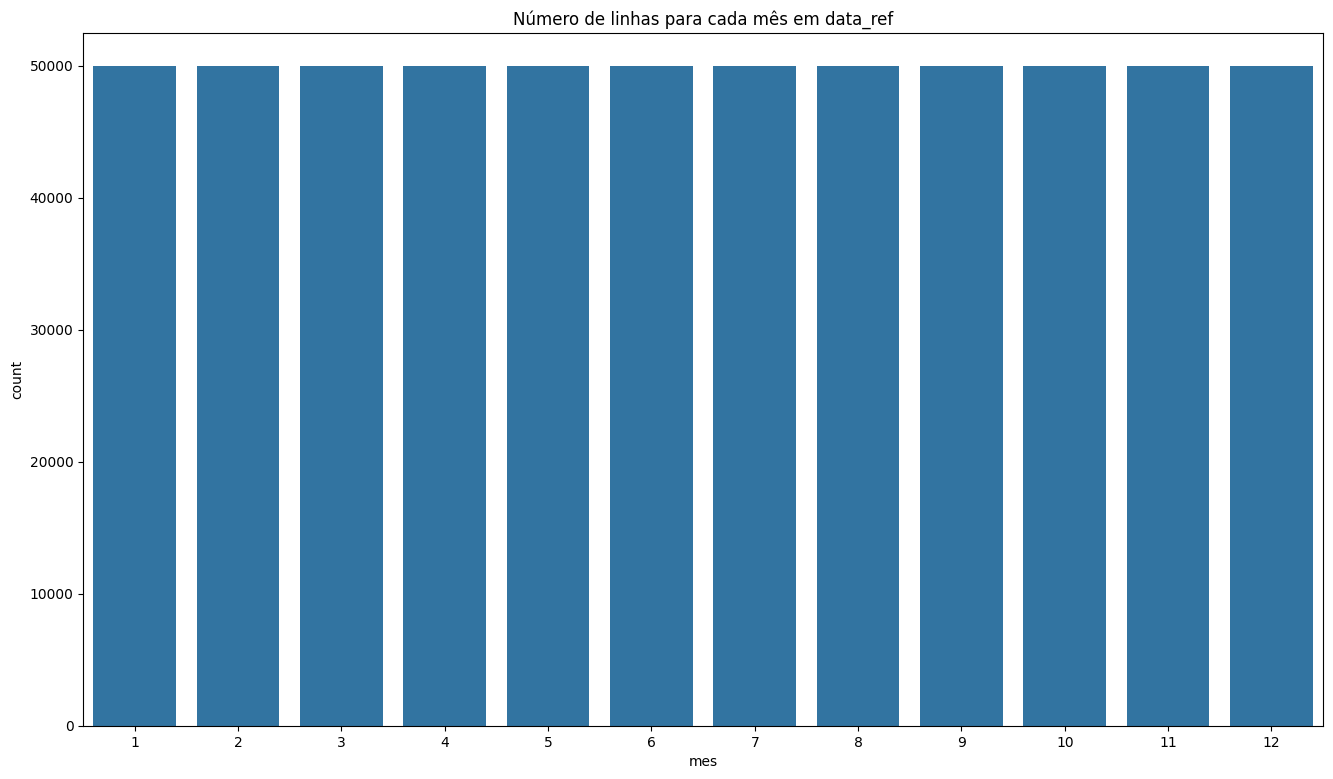

In [9]:
# Número de linhas para cada mes em data_ref

fig, ax = plt.subplots(figsize=(16,9))

sns.countplot(data=df_train, x='mes', ax=ax)
ax.set_title('Número de linhas para cada mês em data_ref')

plt.show()

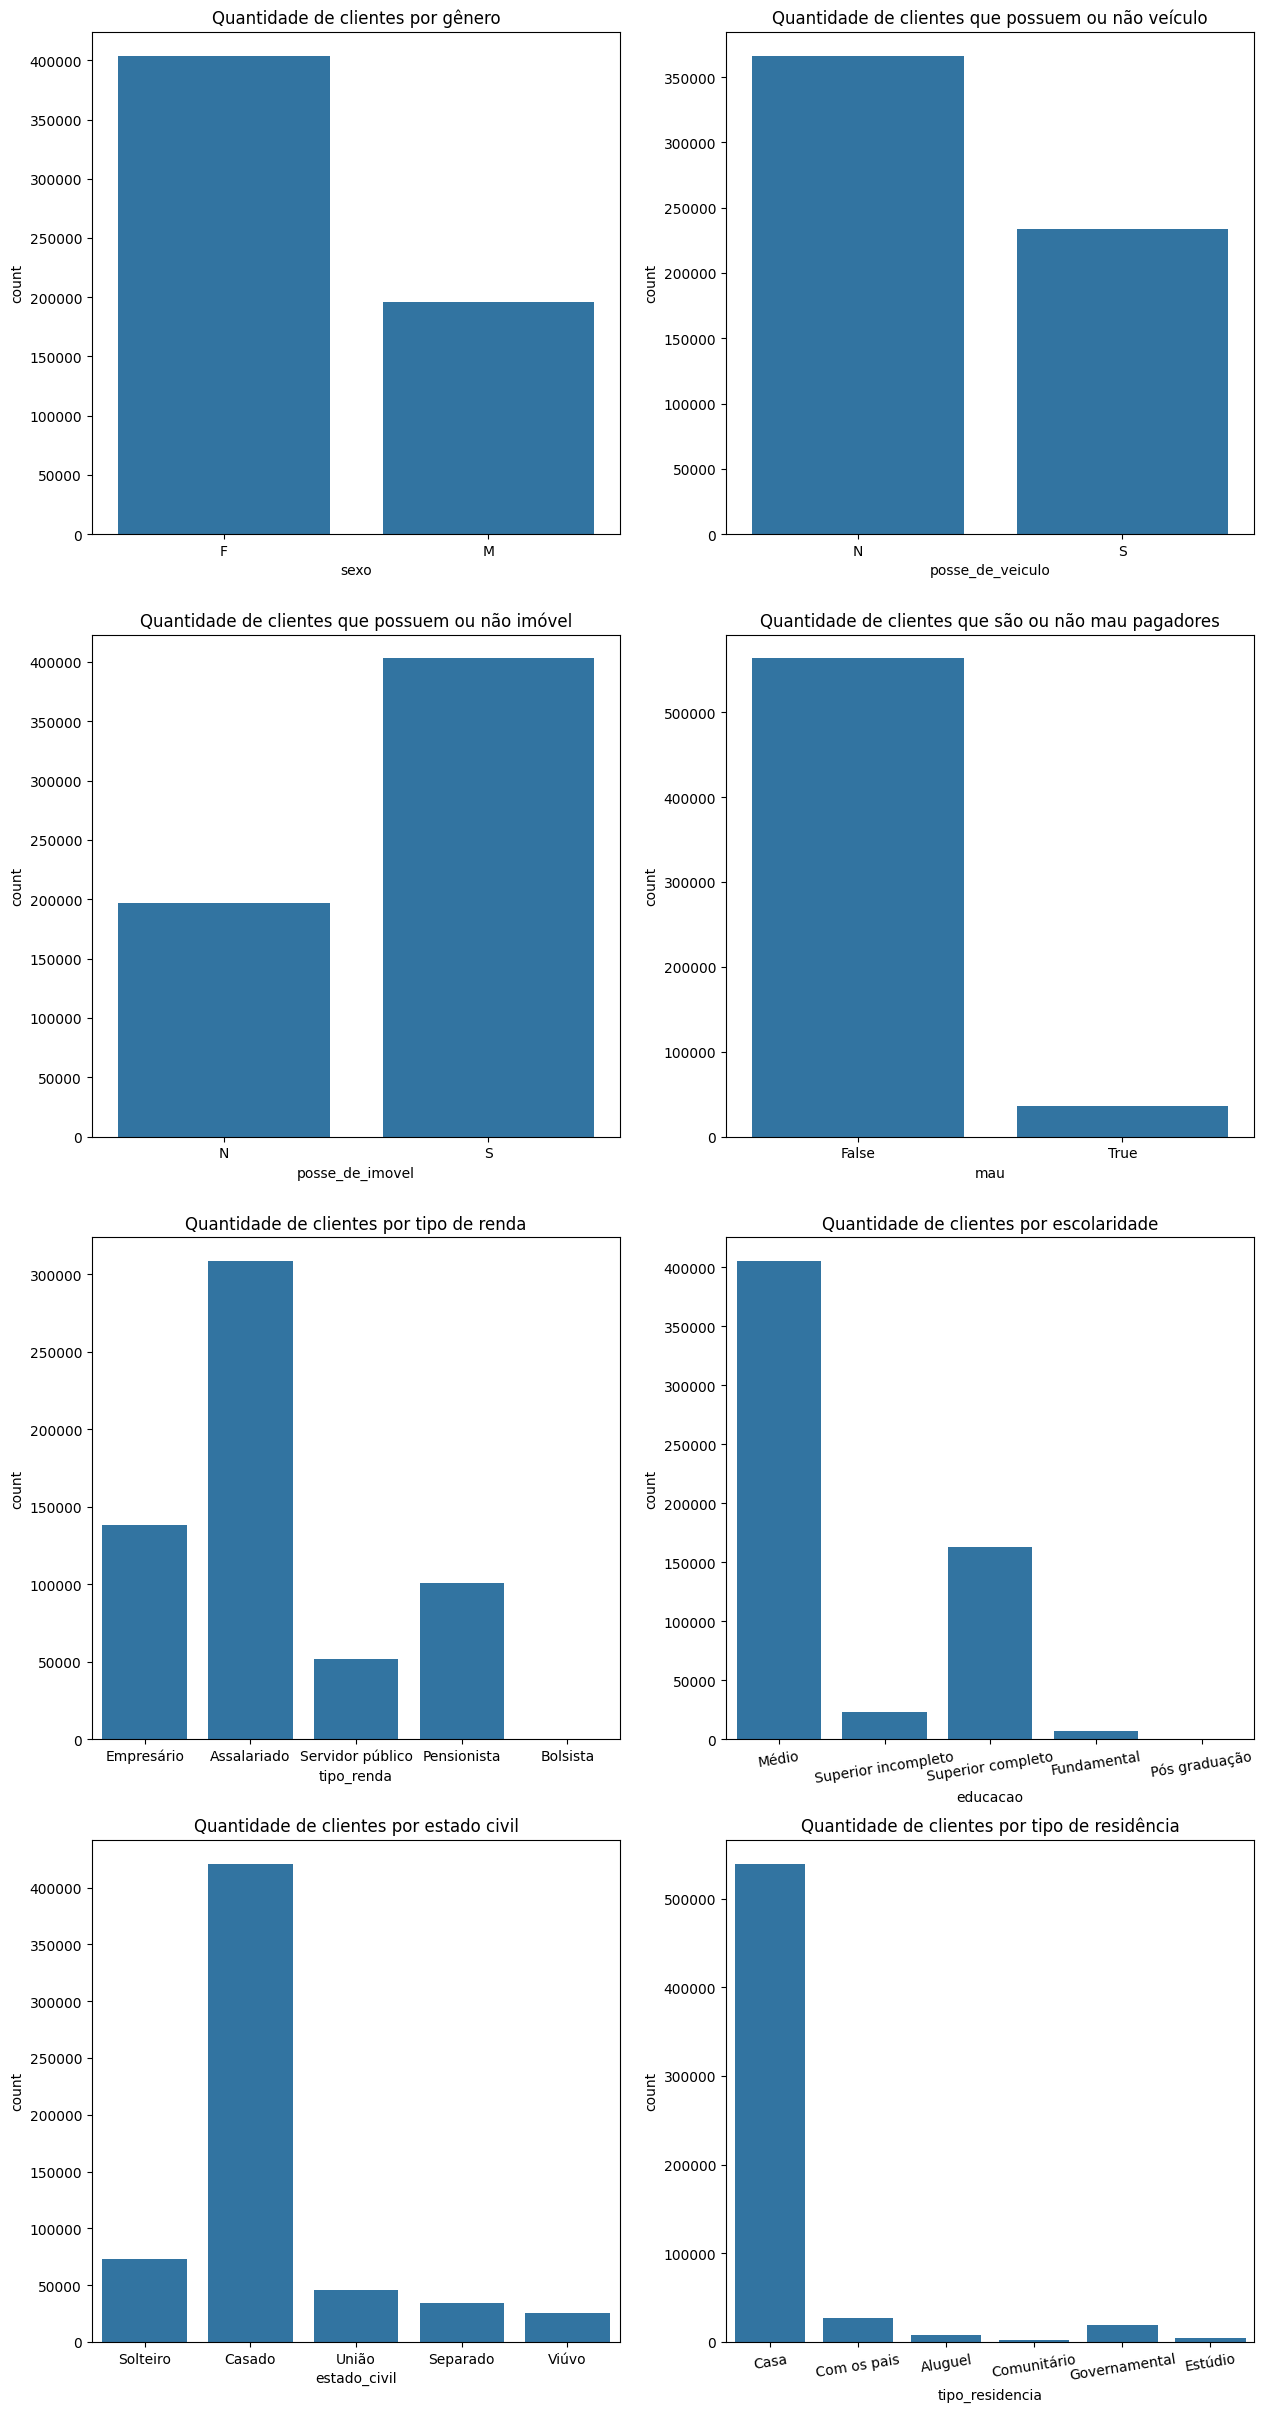

In [10]:
# Variáveis qualitativas
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(15,30))

sns.countplot(data=df_train, x='sexo', ax=ax[0,0])
ax[0,0].set_title('Quantidade de clientes por gênero')

sns.countplot(data=df_train, x='posse_de_veiculo', ax=ax[0,1])
ax[0,1].set_title('Quantidade de clientes que possuem ou não veículo')

sns.countplot(data=df_train, x='posse_de_imovel', ax=ax[1,0])
ax[1,0].set_title('Quantidade de clientes que possuem ou não imóvel')

sns.countplot(data=df_train, x='mau', ax=ax[1,1])
ax[1,1].set_title('Quantidade de clientes que são ou não mau pagadores')

sns.countplot(data=df_train, x='tipo_renda', ax=ax[2,0])
ax[2,0].set_title('Quantidade de clientes por tipo de renda')

sns.countplot(data=df_train, x='educacao', ax=ax[2,1])
ax[2,1].set_title('Quantidade de clientes por escolaridade')
for tick in ax[2,1].get_xticklabels():
    tick.set_rotation(9)

sns.countplot(data=df_train, x='estado_civil', ax=ax[3,0])
ax[3,0].set_title('Quantidade de clientes por estado civil')

sns.countplot(data=df_train, x='tipo_residencia', ax=ax[3,1])
ax[3,1].set_title('Quantidade de clientes por tipo de residência')
for tick in ax[3,1].get_xticklabels():
    tick.set_rotation(9)
    
plt.show()

Text(0.5, 1.0, 'Quantidade de clientes por renda')

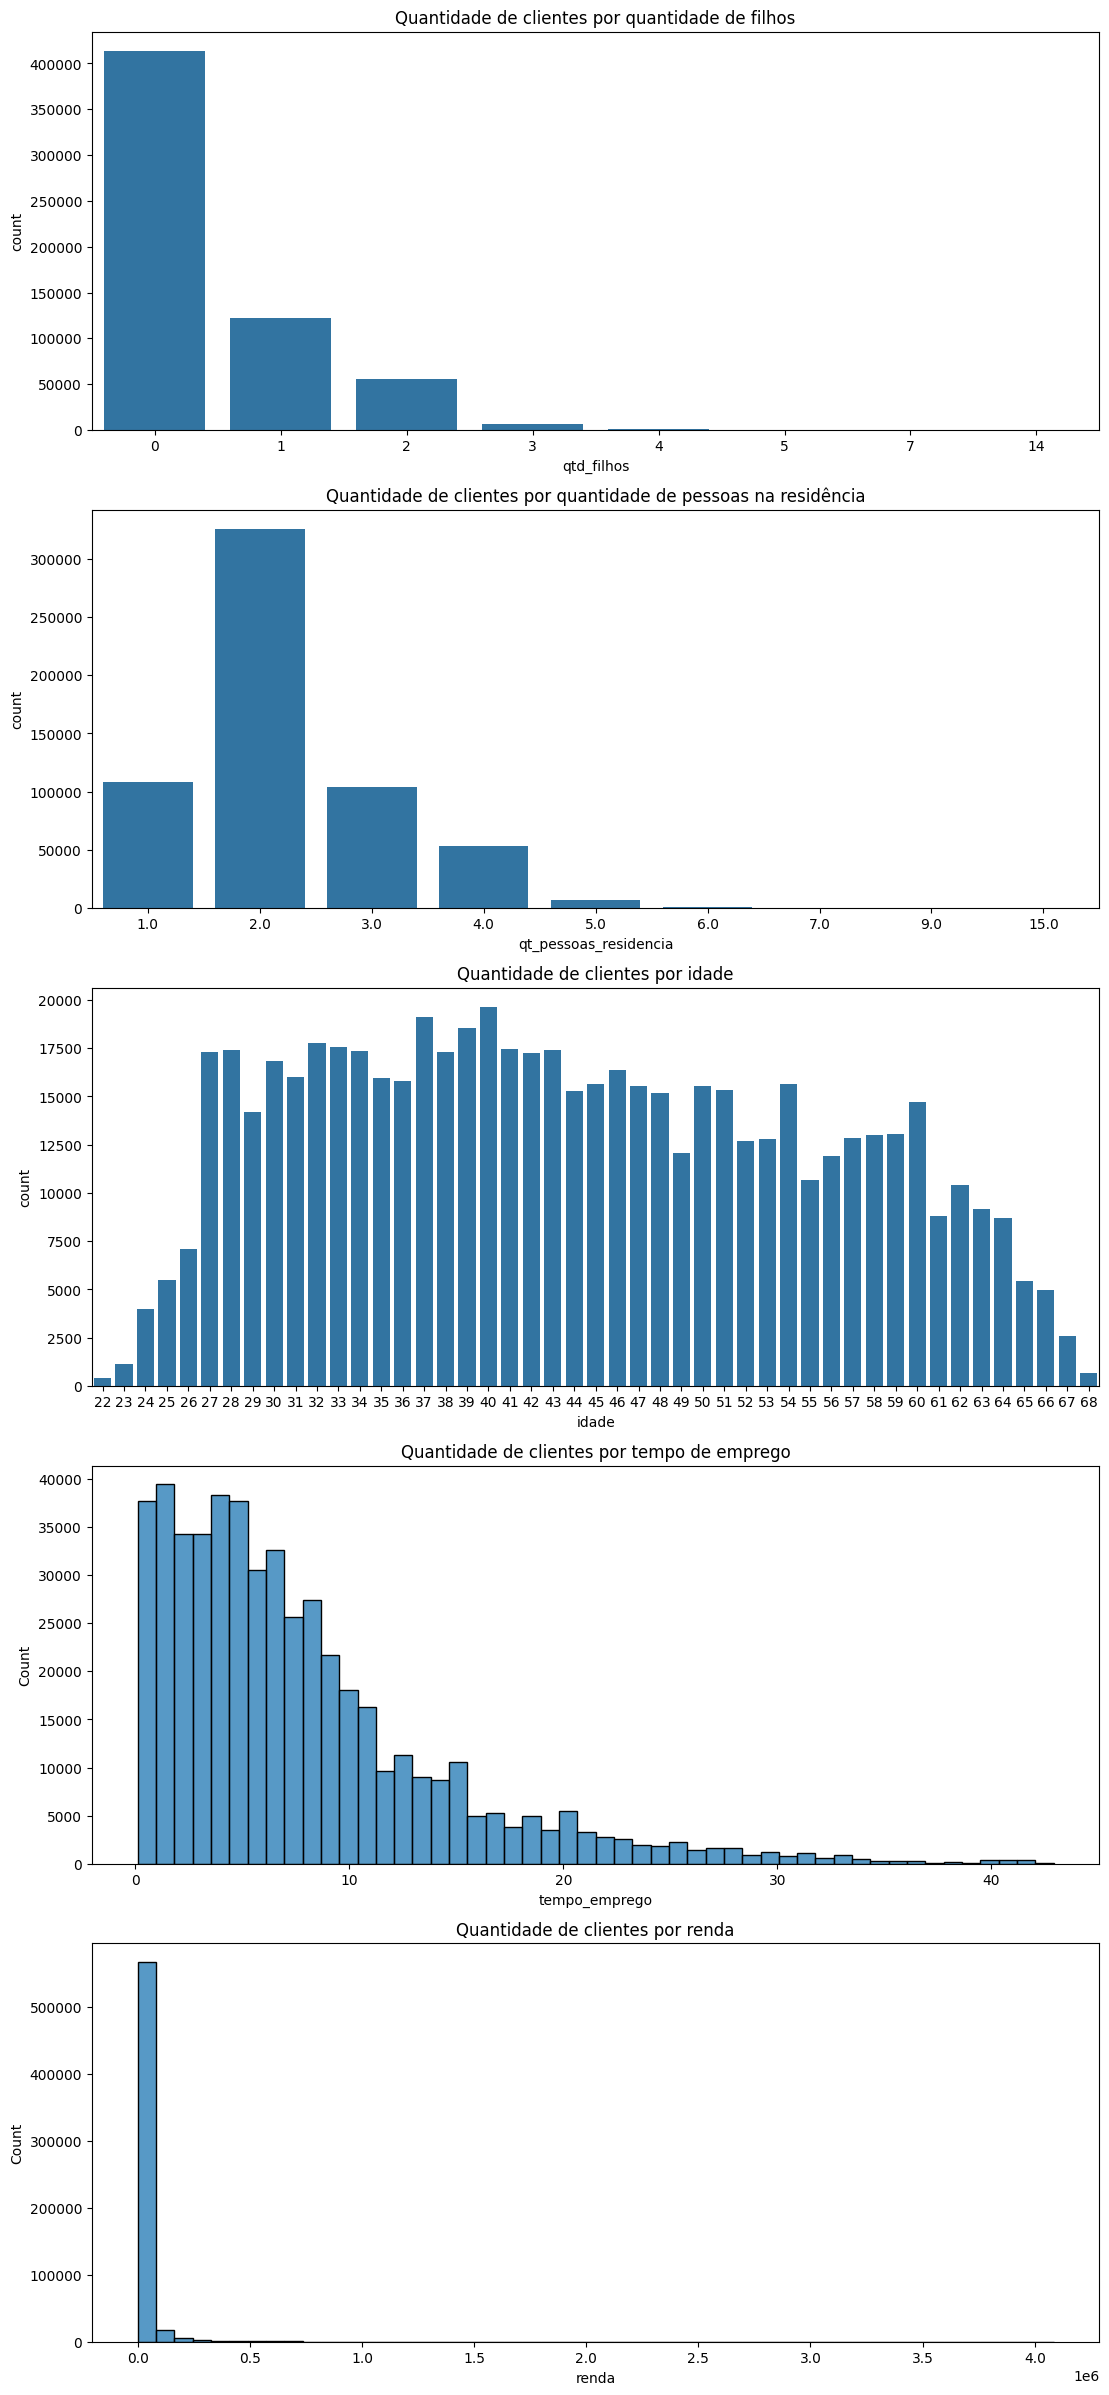

In [11]:
# variáveis quantitativas

fig, ax = plt.subplots(nrows=5, figsize=(13,30))

sns.countplot(data=df_train, x='qtd_filhos', ax=ax[0])
ax[0].set_title('Quantidade de clientes por quantidade de filhos')

sns.countplot(data=df_train, x='qt_pessoas_residencia',ax=ax[1])
ax[1].set_title('Quantidade de clientes por quantidade de pessoas na residência')

sns.countplot(data=df_train, x='idade', ax=ax[2])
ax[2].set_title('Quantidade de clientes por idade')

sns.histplot(data=df_train, x='tempo_emprego', bins=50, ax=ax[3])
ax[3].set_title('Quantidade de clientes por tempo de emprego')

sns.histplot(data=df_train, x='renda', bins=50, ax=ax[4])
ax[4].set_title('Quantidade de clientes por renda')

## Descritiva bivariada

Faça uma análise descritiva bivariada de cada variável

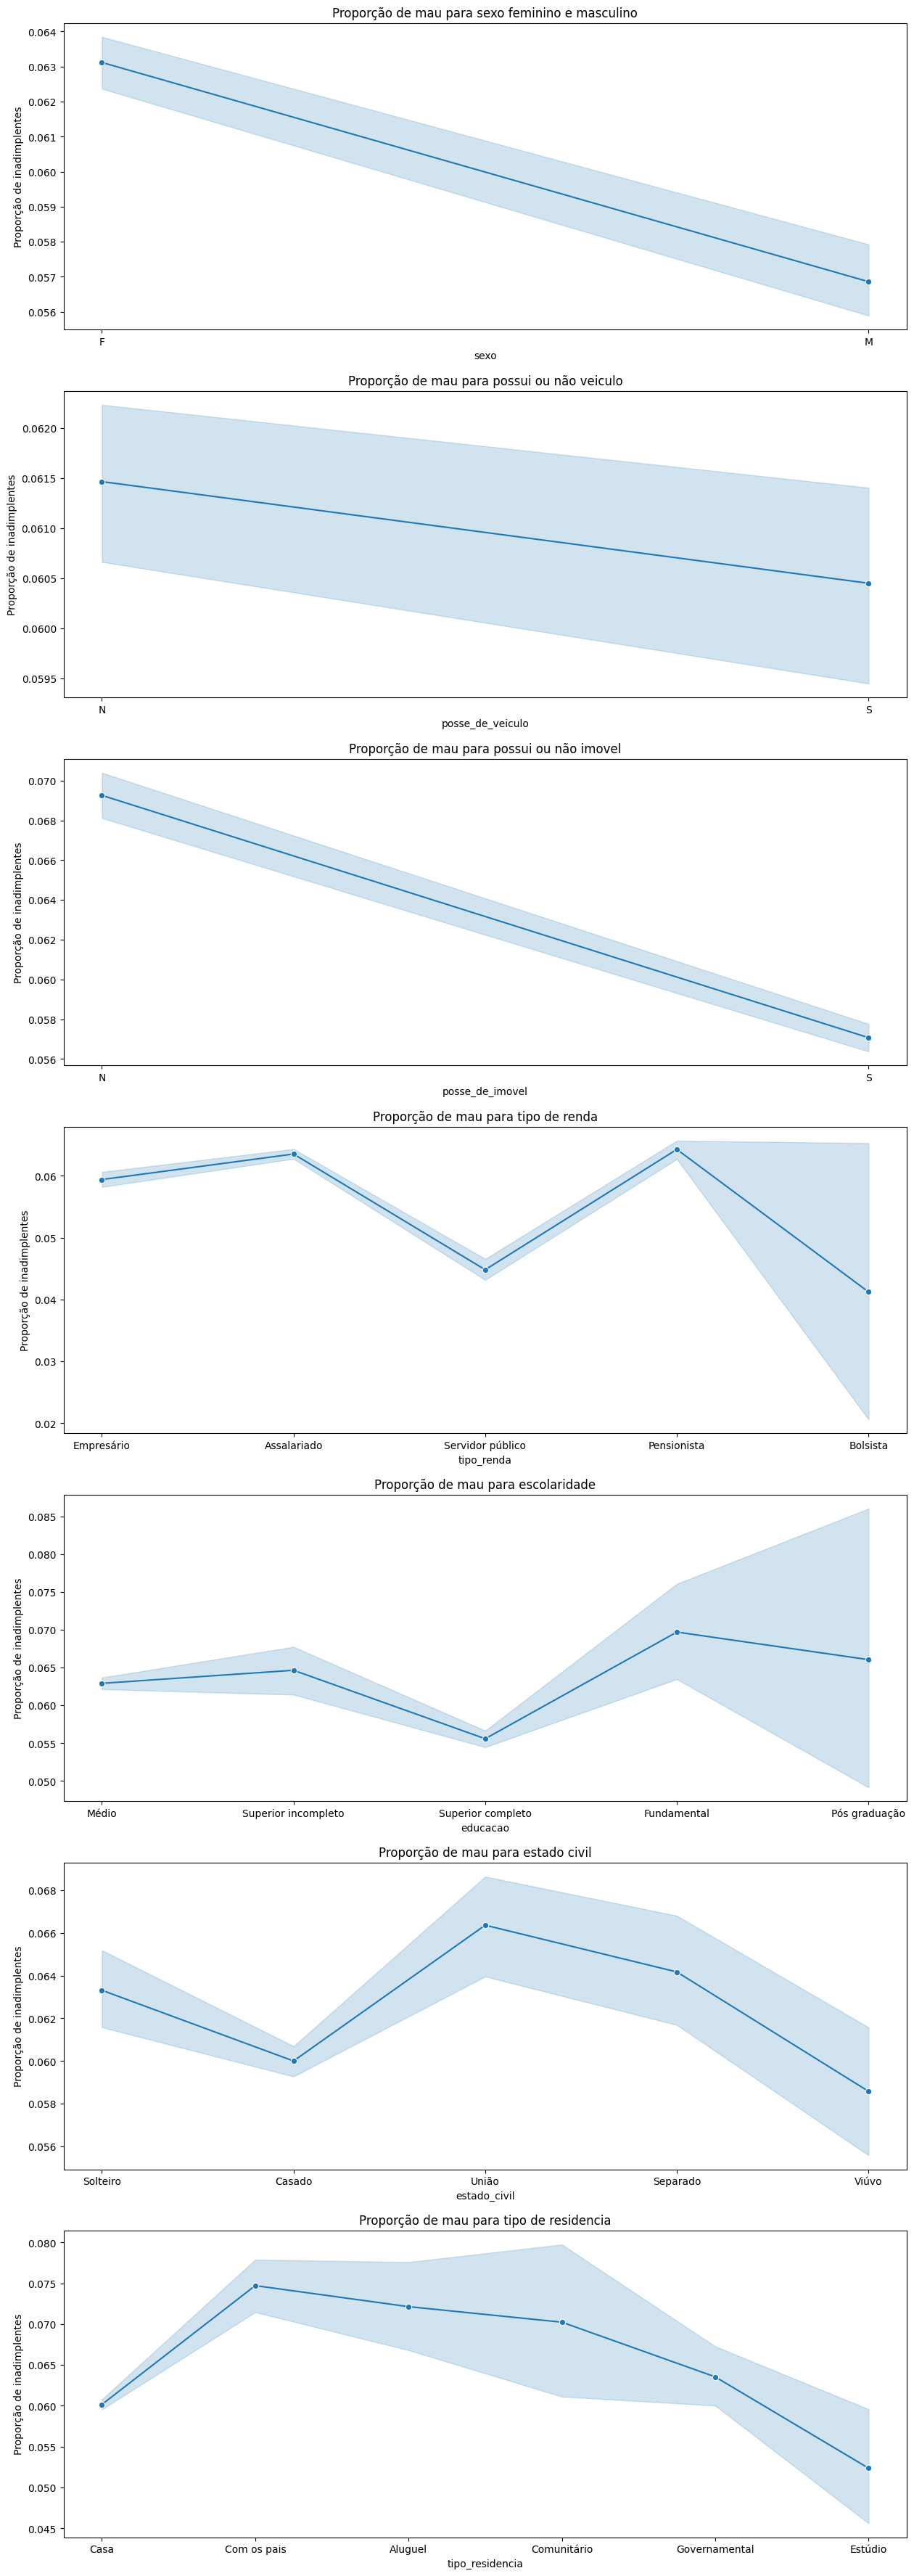

In [12]:
fig, ax = plt.subplots(nrows=7, figsize=(15, 45))

sns.lineplot(data=df_train, x='sexo', y='mau', ax=ax[0], marker='o')
ax[0].set_title('Proporção de mau para sexo feminino e masculino')
ax[0].set_ylabel("Proporção de inadimplentes")

sns.lineplot(data=df_train, x='posse_de_veiculo', y='mau', ax=ax[1], marker='o')
ax[1].set_title('Proporção de mau para possui ou não veiculo')
ax[1].set_ylabel("Proporção de inadimplentes")

sns.lineplot(data=df_train, x='posse_de_imovel', y='mau', ax=ax[2], marker='o')
ax[2].set_title('Proporção de mau para possui ou não imovel')
ax[2].set_ylabel("Proporção de inadimplentes")

sns.lineplot(data=df_train, x='tipo_renda', y='mau', ax=ax[3], marker='o')
ax[3].set_title('Proporção de mau para tipo de renda')
ax[3].set_ylabel("Proporção de inadimplentes")

sns.lineplot(data=df_train, x='educacao', y='mau', ax=ax[4], marker='o')
ax[4].set_title('Proporção de mau para escolaridade')
ax[4].set_ylabel("Proporção de inadimplentes")

sns.lineplot(data=df_train, x='estado_civil', y='mau', ax=ax[5], marker='o')
ax[5].set_title('Proporção de mau para estado civil')
ax[5].set_ylabel("Proporção de inadimplentes")

sns.lineplot(data=df_train, x='tipo_residencia', y='mau', ax=ax[6], marker='o')
ax[6].set_title('Proporção de mau para tipo de residencia')
ax[6].set_ylabel("Proporção de inadimplentes")

plt.show()

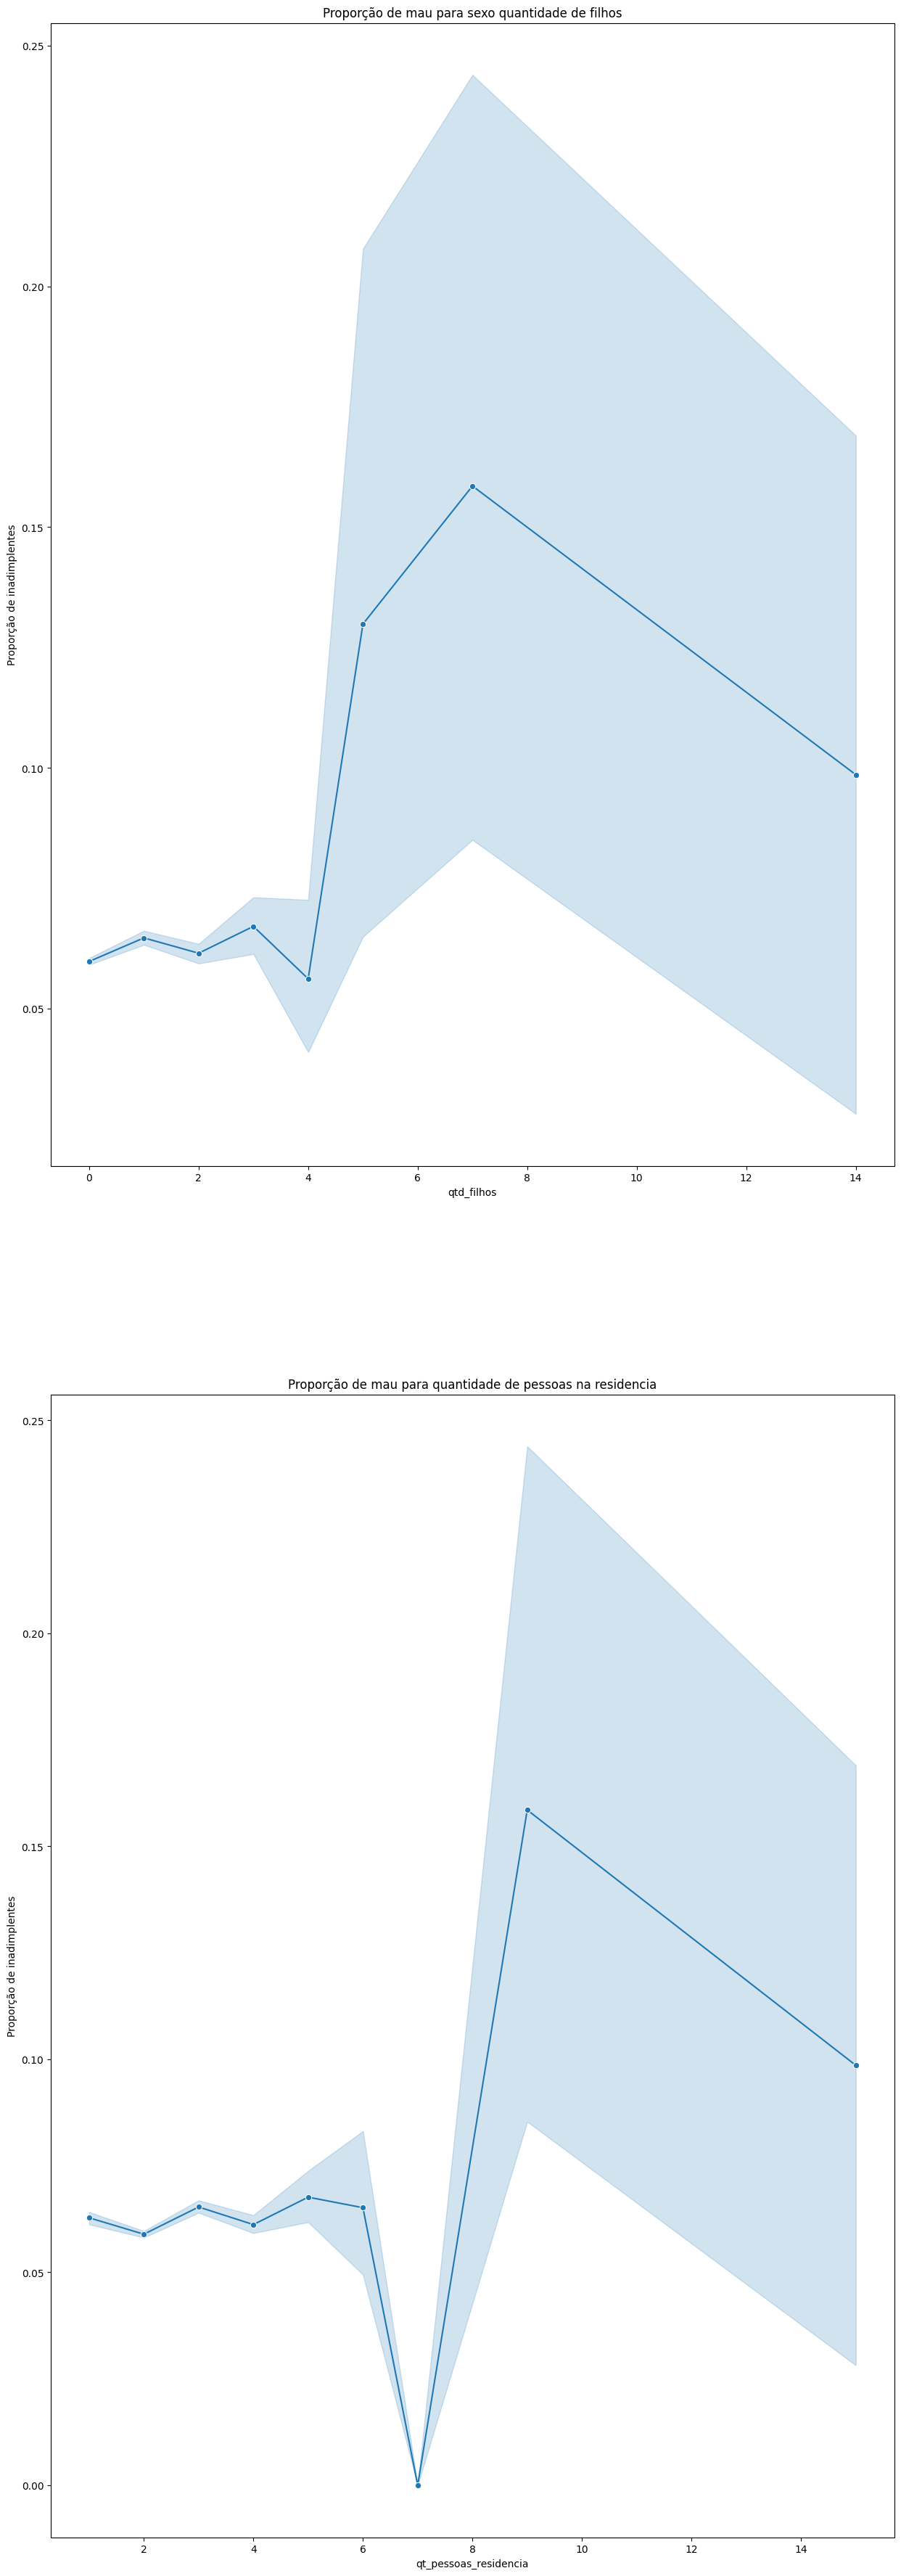

In [13]:
fig, ax = plt.subplots(nrows=2, figsize=(15, 45))

sns.lineplot(data=df_train, x='qtd_filhos', y='mau', ax=ax[0], marker='o')
ax[0].set_title('Proporção de mau para sexo quantidade de filhos')
ax[0].set_ylabel("Proporção de inadimplentes")

sns.lineplot(data=df_train, x='qt_pessoas_residencia', y='mau', ax=ax[1], marker='o')
ax[1].set_title('Proporção de mau para quantidade de pessoas na residencia')
ax[1].set_ylabel("Proporção de inadimplentes")

plt.show()

Text(0.5, 1.0, 'Proporção de mau por idade')

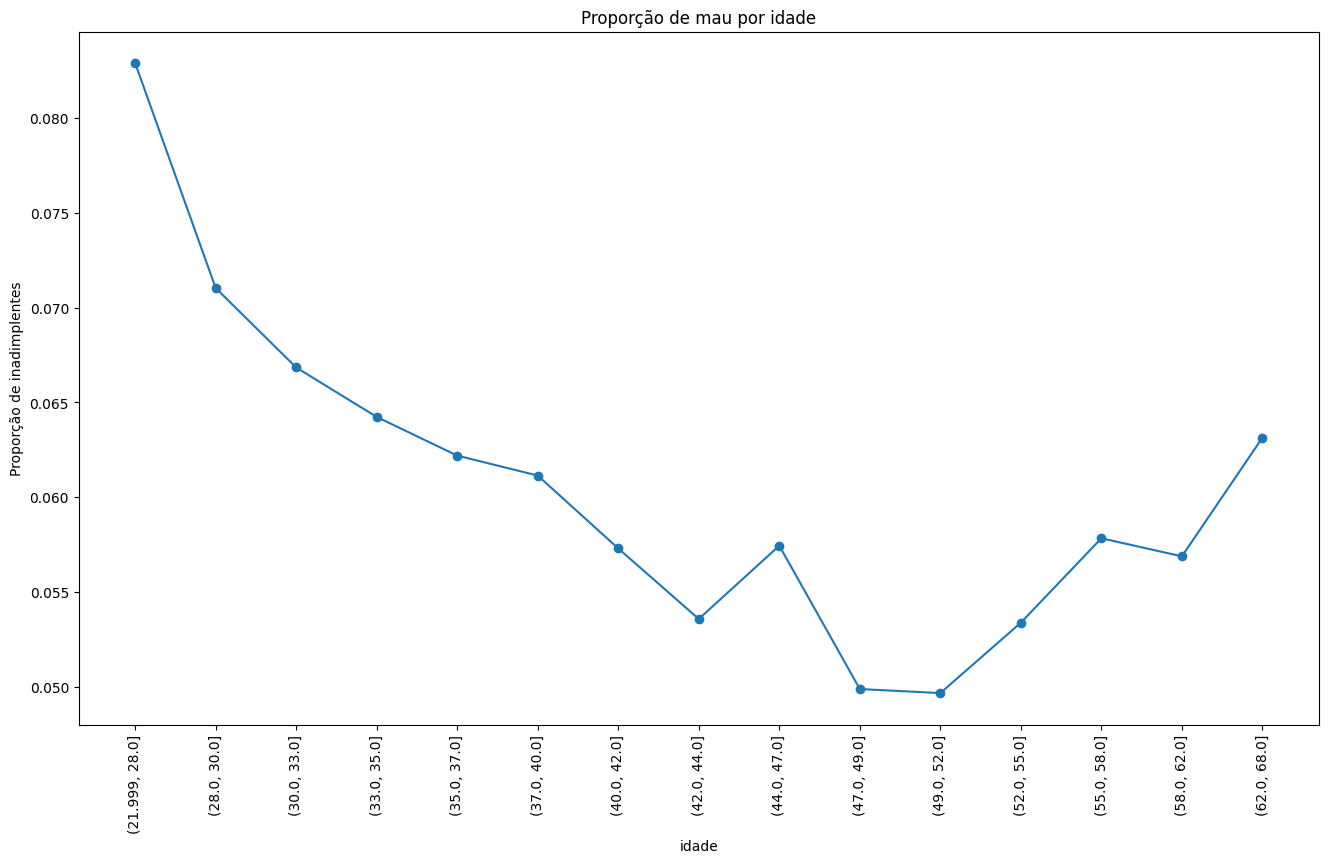

In [14]:
fig, ax = plt.subplots(figsize=(16,9))

cat_1, bins = pd.qcut(df_train['idade'], 15, retbins=True)
df_1 = df_train.groupby(cat_1)
biv = df_1['mau'].mean()

ax = biv.plot.line(marker='o')
ax.set_ylabel("Proporção de inadimplentes")
ticks = plt.xticks(range(len(biv.index.values)), biv.index.values, rotation = 90)
ax.set_title('Proporção de mau por idade')

Text(0.5, 1.0, 'Proporção de mau por tempo de emprego')

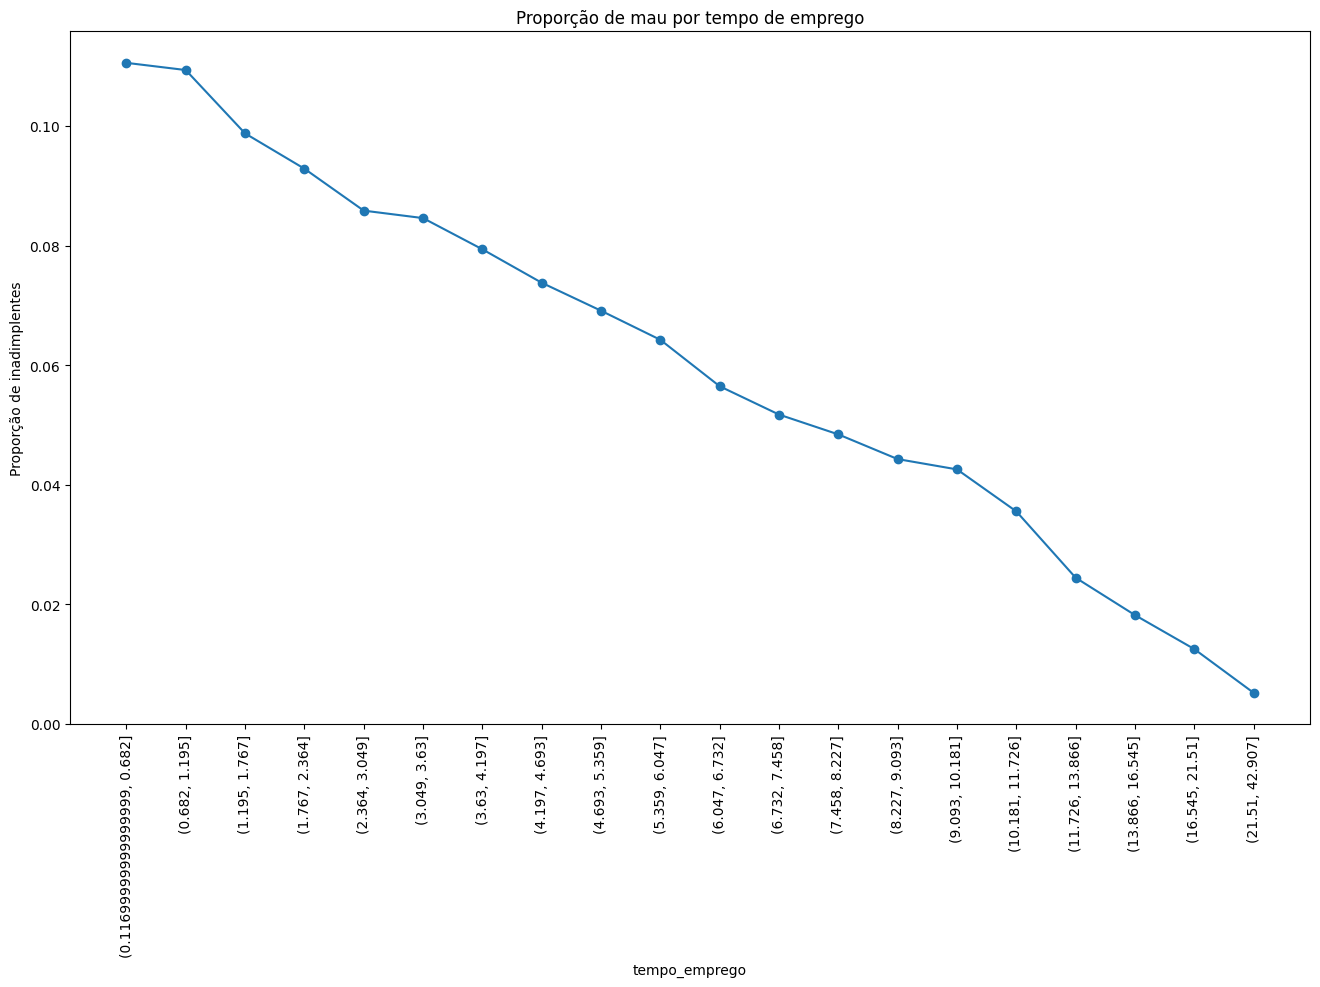

In [15]:
fig, ax = plt.subplots(figsize=(16,9))

cat_1, bins = pd.qcut(df_train['tempo_emprego'], 20, retbins=True)
df_1 = df_train.groupby(cat_1)
biv = df_1['mau'].mean()

ax = biv.plot.line(marker='o')
ax.set_ylabel("Proporção de inadimplentes")
ticks = plt.xticks(range(len(biv.index.values)), biv.index.values, rotation = 90)
ax.set_title('Proporção de mau por tempo de emprego')

Text(0.5, 1.0, 'Proporção de mau por renda')

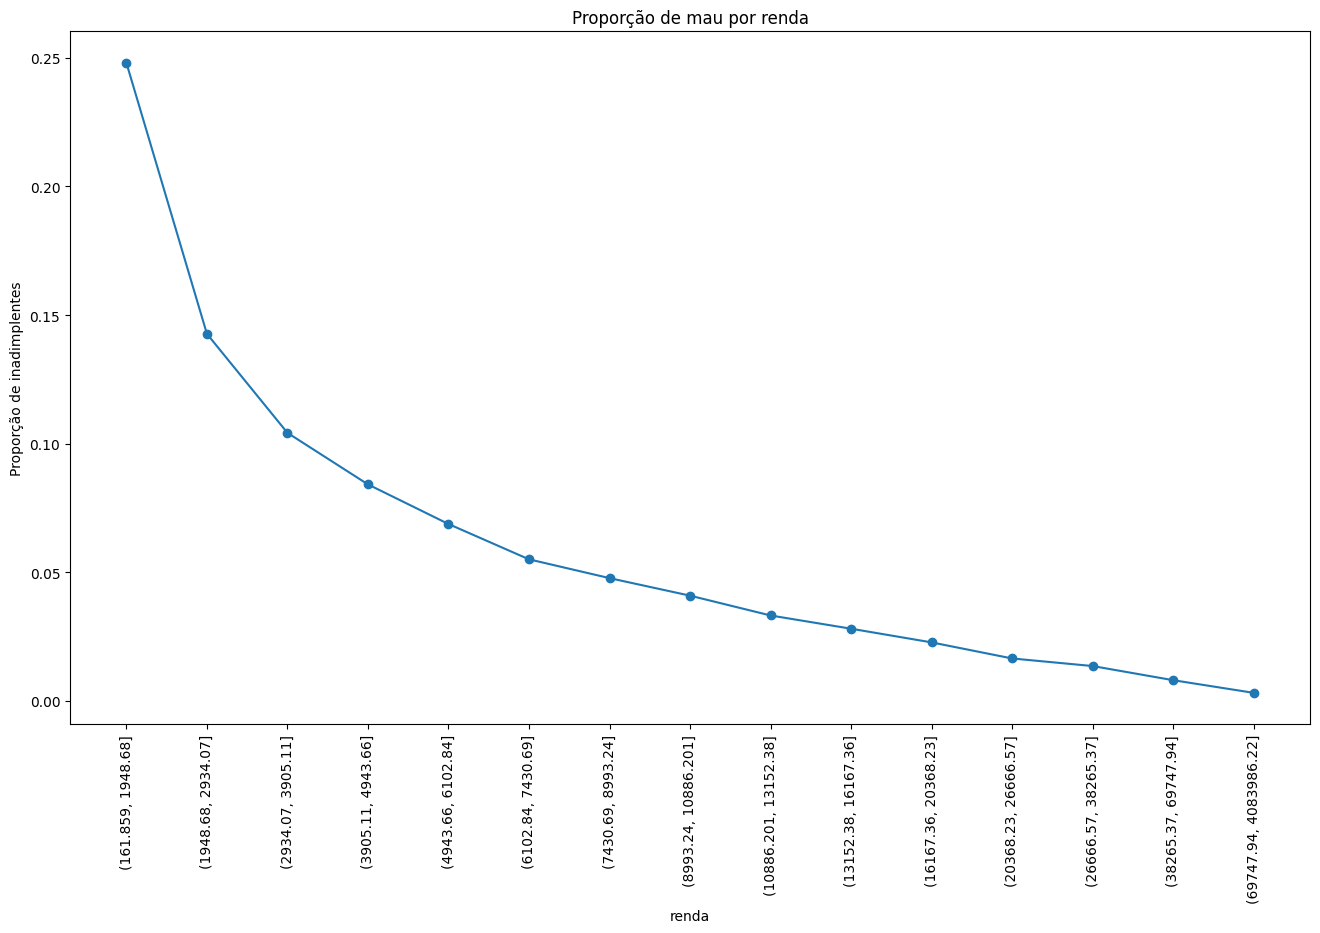

In [16]:
fig, ax = plt.subplots(figsize=(16,9))

cat_1, bins = pd.qcut(df_train['renda'], 15, retbins=True)
df_1 = df_train.groupby(cat_1)
biv = df_1['mau'].mean()

ax = biv.plot.line(marker='o')
ax.set_ylabel("Proporção de inadimplentes")
ticks = plt.xticks(range(len(biv.index.values)), biv.index.values, rotation = 90)
ax.set_title('Proporção de mau por renda')

## Desenvolvimento do modelo

Desenvolva um modelo de *credit scoring* através de uma regressão logística.

- Trate valores missings e outliers
- Trate 'zeros estruturais'
- Faça agrupamentos de categorias conforme vimos em aula
- Proponha uma equação preditiva para 'mau'
- Caso hajam categorias não significantes, justifique

In [17]:
df_train['mau'] = df_train.mau.astype('int64')
df_train.drop(columns = ['data_ref', 'index', 'mes'], inplace=True)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600000 entries, 0 to 599999
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   sexo                   600000 non-null  object 
 1   posse_de_veiculo       600000 non-null  object 
 2   posse_de_imovel        600000 non-null  object 
 3   qtd_filhos             600000 non-null  int64  
 4   tipo_renda             600000 non-null  object 
 5   educacao               600000 non-null  object 
 6   estado_civil           600000 non-null  object 
 7   tipo_residencia        600000 non-null  object 
 8   idade                  600000 non-null  int64  
 9   tempo_emprego          499125 non-null  float64
 10  qt_pessoas_residencia  600000 non-null  float64
 11  renda                  600000 non-null  float64
 12  mau                    600000 non-null  int64  
dtypes: float64(3), int64(3), object(7)
memory usage: 59.5+ MB


In [18]:
df_train['tempo_emprego'].fillna(value=df_train['tempo_emprego'].mean(), inplace=True)

In [19]:
metadados = pd.DataFrame(df_train.dtypes, columns=['dtype'])
metadados['nmissing'] = df_train.isna().sum()
metadados['valores_unicos'] = df_train.nunique()
metadados['papel'] = 'covariavel'
metadados.loc['mau','papel'] = 'resposta'
metadados

,dtype,nmissing,valores_unicos,papel
sexo,object,0,2,covariavel
posse_de_veiculo,object,0,2,covariavel
posse_de_imovel,object,0,2,covariavel
qtd_filhos,int64,0,8,covariavel
tipo_renda,object,0,5,covariavel
educacao,object,0,5,covariavel
estado_civil,object,0,5,covariavel
tipo_residencia,object,0,6,covariavel
idade,int64,0,47,covariavel
tempo_emprego,float64,0,3005,covariavel


In [20]:
def IV(variavel, resposta):
    tab = pd.crosstab(variavel, resposta, margins=True, margins_name='total')

    rótulo_evento = tab.columns[0]
    rótulo_nao_evento = tab.columns[1]

    tab['pct_evento'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]
    tab['ep'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]
    
    tab['pct_nao_evento'] = tab[rótulo_nao_evento]/tab.loc['total',rótulo_nao_evento]
    tab['woe'] = np.log(tab.pct_evento/tab.pct_nao_evento)
    tab['iv_parcial'] = (tab.pct_evento - tab.pct_nao_evento)*tab.woe
    return tab['iv_parcial'].sum()

In [21]:
for var in metadados[metadados.papel=='covariavel'].index:
    if  (metadados.loc[var, 'valores_unicos']>10):
        metadados.loc[var, 'IV'] = IV(pd.qcut(df_train[var],5,duplicates='drop'), df_train.mau)
    else: 
        metadados.loc[var, 'IV'] = IV(df_train[var], df_train.mau)
    
metadados

,dtype,nmissing,valores_unicos,papel,IV
sexo,object,0,2,covariavel,0.002665
posse_de_veiculo,object,0,2,covariavel,0.000075
posse_de_imovel,object,0,2,covariavel,0.009690
qtd_filhos,int64,0,8,covariavel,0.001689
tipo_renda,object,0,5,covariavel,0.009718
educacao,object,0,5,covariavel,0.003690
estado_civil,object,0,5,covariavel,0.001305
tipo_residencia,object,0,6,covariavel,0.003330
idade,int64,0,47,covariavel,0.018434
tempo_emprego,float64,0,3005,covariavel,0.283956


In [23]:
def biv_discreta(var, df):
    df['bom'] = 1-df.mau
    g = df.groupby(var)

    biv = pd.DataFrame({'qt_bom': g['bom'].sum(),
                        'qt_mau': g['mau'].sum(),
                        'mau':g['mau'].mean(), 
                        var: g['mau'].mean().index, 
                        'cont':g[var].count()})
    
    biv['ep'] = (biv.mau*(1-biv.mau)/biv.cont)**.5
    biv['mau_sup'] = biv.mau+t.ppf([0.975], biv.cont-1)*biv.ep
    biv['mau_inf'] = biv.mau+t.ppf([0.025], biv.cont-1)*biv.ep
    
    biv['logit'] = np.log(biv.mau/(1-biv.mau))
    biv['logit_sup'] = np.log(biv.mau_sup/(1-biv.mau_sup))
    biv['logit_inf'] = np.log(biv.mau_inf/(1-biv.mau_inf))

    tx_mau_geral = df.mau.mean()
    woe_geral = np.log(df.mau.mean() / (1 - df.mau.mean()))

    biv['woe'] = biv.logit - woe_geral
    biv['woe_sup'] = biv.logit_sup - woe_geral
    biv['woe_inf'] = biv.logit_inf - woe_geral

    fig, ax = plt.subplots(2,1, figsize=(8,6))
    ax[0].plot(biv[var], biv.woe, ':bo', label='woe')
    ax[0].plot(biv[var], biv.woe_sup, 'o:r', label='limite superior')
    ax[0].plot(biv[var], biv.woe_inf, 'o:r', label='limite inferior')
    
    num_cat = biv.shape[0]
    ax[0].set_xlim([-.3, num_cat-.7])

    ax[0].set_ylabel("Weight of Evidence")
    ax[0].legend(bbox_to_anchor=(.83, 1.17), ncol=3)
    
    ax[0].set_xticks(list(range(num_cat)))
    ax[0].set_xticklabels(biv[var], rotation=8)
    
    ax[1] = biv.cont.plot.bar()
    return biv

0.009634301334170859

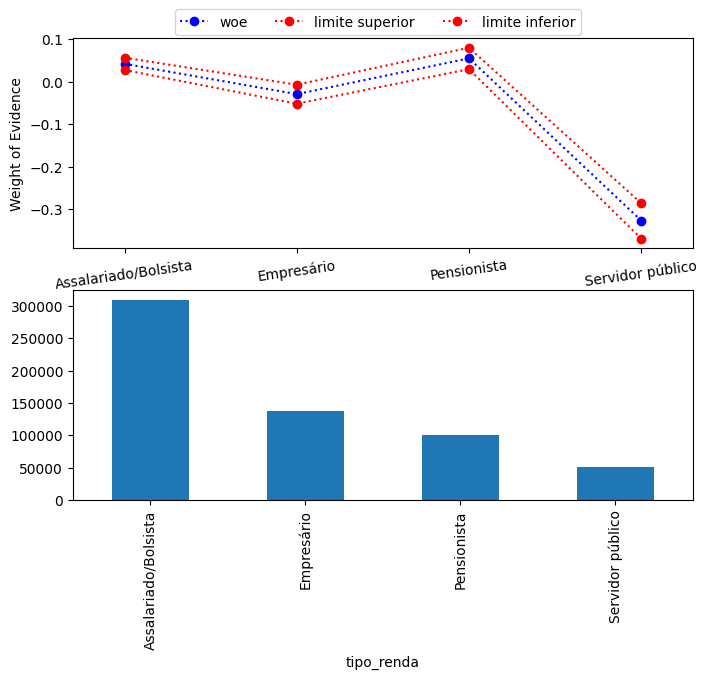

In [24]:
#Agrupamento para tipo de renda pois bolsista está com um valor muito baixo portanto irei juntar com assalariado
df_train.tipo_renda.replace({'Assalariado':'Assalariado/Bolsista', 
                      'Bolsista':'Assalariado/Bolsista',
                     }, inplace=True)

biv_discreta('tipo_renda', df_train);
IV(df_train.tipo_renda, df_train.mau)

0.0034801108923340892

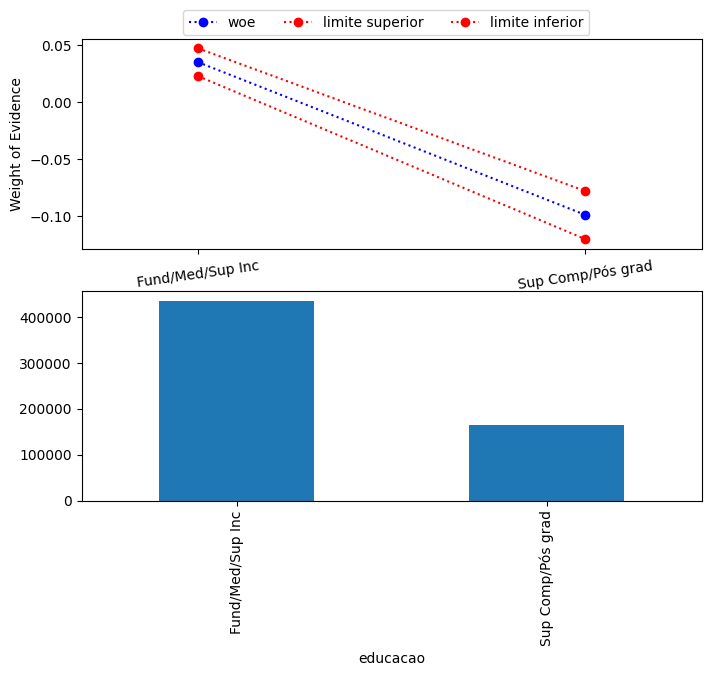

In [25]:
df_train.educacao.replace({'Fundamental':'Fund/Med/Sup Inc', 
                      'Médio':'Fund/Med/Sup Inc',
                      'Superior incompleto':'Fund/Med/Sup Inc',
                      'Superior completo': 'Sup Comp/Pós grad',
                      'Pós graduação': 'Sup Comp/Pós grad'
                     }, inplace=True)

biv_discreta('educacao', df_train);
IV(df_train.educacao, df_train.mau)

0.0034801108923340892

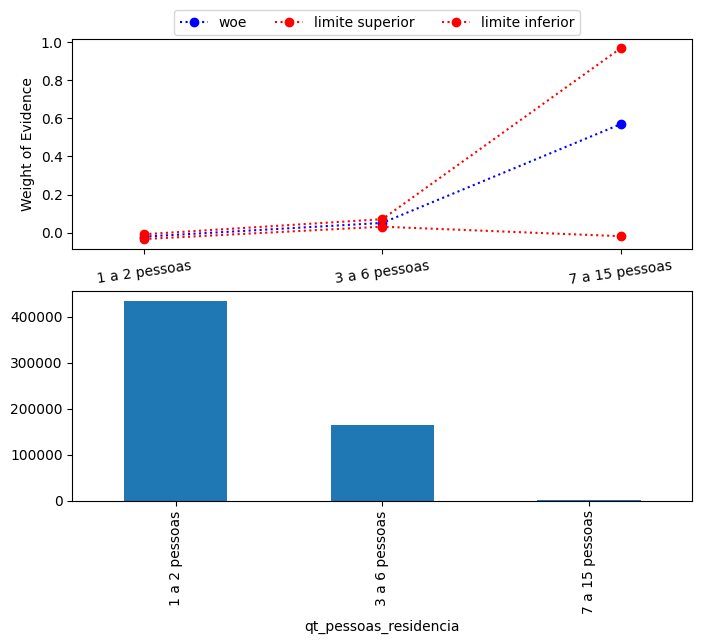

In [26]:
# ajustando 0 estrutural para qt_pessoas_residencia

df_train.qt_pessoas_residencia.replace({1.0 :'1 a 2 pessoas', 
                      2.0 :'1 a 2 pessoas',
                      3.0 :'3 a 6 pessoas',
                      4.0 :'3 a 6 pessoas',
                      5.0 :'3 a 6 pessoas',
                      6.0 :'3 a 6 pessoas',
                      7.0 :'7 a 15 pessoas',
                      9.0 :'7 a 15 pessoas',
                      15.0 :'7 a 15 pessoas',
                     }, inplace=True)

biv_discreta('qt_pessoas_residencia', df_train);
IV(df_train.educacao, df_train.mau)

In [27]:
#Criacao do modelo
formula = '''
    mau ~ sexo + posse_de_veiculo + posse_de_imovel + qtd_filhos + tipo_renda + 
    educacao + estado_civil + tipo_residencia + idade + tempo_emprego +
    renda
'''

rl = smf.glm(formula, data=df_train, family=sm.families.Binomial()).fit()

rl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    mau   No. Observations:               600000
Model:                            GLM   Df Residuals:                   599979
Model Family:                Binomial   Df Model:                           20
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.2488e+05
Date:                Thu, 15 Aug 2024   Deviance:                   2.4965e+05
Time:                        20:30:12   Pearson chi2:                 1.57e+16
No. Iterations:                    11   Pseudo R-squ. (CS):            0.04260
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                           -1.4189      0.053    -26.825      0.000      -1.523      -1.315
sexo[T.M]                           -0.1255      0.013     -9.567      0.000      -0.151      -0.100
posse_de_veiculo[T.S]                0.0313      0.012      2.529      0.011       0.007       0.056
posse_de_imovel[T.S]                -0.0847      0.012     -7.178      0.000      -0.108      -0.062
tipo_renda[T.Empresário]            -0.0545      0.014     -3.900      0.000      -0.082      -0.027
tipo_renda[T.Pensionista]           -0.0411      0.020     -2.032      0.042      -0.081      -0.001
tipo_renda[T.Servidor público]      -0.0330      0.023     -1.421      0.155      -0.079       0.013
educacao[T.Sup Comp/Pós grad]       -0.0566      0.013     -4.326      0.000      -0.082      -0.031
estado_civil[T.Separado]             0.0374      0.024      1.574      0.116      -0.009       0.084
estado_civil[T.Solteiro]             0.0054      0.017      0.311      0.756      -0.029       0.039
estado_civil[T.União]                0.0472      0.020      2.322      0.020       0.007       0.087
estado_civil[T.Viúvo]               -0.0346      0.029     -1.192      0.233      -0.092       0.022
tipo_residencia[T.Casa]             -0.0879      0.044     -1.995      0.046      -0.174      -0.002
tipo_residencia[T.Com os pais]      -0.0731      0.050     -1.475      0.140      -0.170       0.024
tipo_residencia[T.Comunitário]      -0.1403      0.089     -1.572      0.116      -0.315       0.035
tipo_residencia[T.Estúdio]          -0.0327      0.082     -0.397      0.691      -0.194       0.129
tipo_residencia[T.Governamental]    -0.0834      0.053     -1.565      0.118      -0.188       0.021
qtd_filhos                           0.0036      0.008      0.448      0.654      -0.012       0.019
idade                                0.0003      0.001      0.394      0.693      -0.001       0.002
tempo_emprego                       -0.0236      0.002    -13.100      0.000      -0.027      -0.020
renda                               -0.0001   1.09e-06    -93.691      0.000      -0.000   -9.96e-05
====================================================================================================
"""

In [28]:
formula = '''
    mau ~ qtd_filhos + posse_de_imovel + tipo_residencia + qt_pessoas_residencia +
    tempo_emprego + renda + idade
'''

rl = smf.glm(formula, data=df_train, family=sm.families.Binomial()).fit()

rl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    mau   No. Observations:               600000
Model:                            GLM   Df Residuals:                   599987
Model Family:                Binomial   Df Model:                           12
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.2495e+05
Date:                Thu, 15 Aug 2024   Deviance:                   2.4978e+05
Time:                        20:30:20   Pearson chi2:                 1.69e+16
No. Iterations:                    11   Pseudo R-squ. (CS):            0.04239
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                                  -1.4955      0.049    -30.706      0.000      -1.591      -1.400
posse_de_imovel[T.S]                       -0.0820      0.012     -6.963      0.000      -0.105      -0.059
tipo_residencia[T.Casa]                    -0.0785      0.044     -1.788      0.074      -0.165       0.008
tipo_residencia[T.Com os pais]             -0.0641      0.049     -1.296      0.195      -0.161       0.033
tipo_residencia[T.Comunitário]             -0.1459      0.089     -1.642      0.101      -0.320       0.028
tipo_residencia[T.Estúdio]                 -0.0564      0.082     -0.686      0.493      -0.218       0.105
tipo_residencia[T.Governamental]           -0.0678      0.053     -1.275      0.202      -0.172       0.036
qt_pessoas_residencia[T.3 a 6 pessoas]     -0.0343      0.024     -1.452      0.146      -0.081       0.012
qt_pessoas_residencia[T.7 a 15 pessoas]     0.0462      0.279      0.166      0.868      -0.500       0.592
qtd_filhos                                  0.0195      0.014      1.347      0.178      -0.009       0.048
tempo_emprego                              -0.0233      0.002    -13.326      0.000      -0.027      -0.020
renda                                      -0.0001   1.08e-06    -95.453      0.000      -0.000      -0.000
idade                                       0.0006      0.001      1.156      0.248      -0.000       0.002
===========================================================================================================
"""

## Avaliação do modelo

Avalie o poder discriminante do modelo pelo menos avaliando acurácia, KS e Gini.

Avalie estas métricas nas bases de desenvolvimento e *out of time*.

In [29]:
# Base de treino
df_train['score'] = rl.predict(df_train)

# Acurácia
acc = metrics.accuracy_score(df_train.mau, df_train.score>.068)
#AUC
fpr, tpr, thresholds = metrics.roc_curve(df_train.mau, df_train.score)
auc = metrics.auc(fpr, tpr)
#Gini
gini = 2*auc -1
ks = ks_2samp(df_train.loc[df_train.mau == 1, 'score'], df_train.loc[df_train.mau != 1, 'score']).statistic

print('Acurácia: {0:.1%} \nAUC: {1:.1%} \nGINI: {2:.1%}\nKS: {3:.1%}'
      .format(acc, auc, gini, ks))

Acurácia: 59.2% 
AUC: 76.7% 
GINI: 53.4%
KS: 39.5%


In [30]:
#Base de teste out of time
df_test['tempo_emprego'].fillna(value=df_test['tempo_emprego'].mean(), inplace=True)

In [31]:
# ajustando 0 estrutural para qt_pessoas_residencia

df_test.qt_pessoas_residencia.replace({1.0 :'1 a 2 pessoas', 
                      2.0 :'1 a 2 pessoas',
                      3.0 :'3 a 6 pessoas',
                      4.0 :'3 a 6 pessoas',
                      5.0 :'3 a 6 pessoas',
                      6.0 :'3 a 6 pessoas',
                      7.0 :'7 a 15 pessoas',
                      9.0 :'7 a 15 pessoas',
                      15.0 :'7 a 15 pessoas',
                     }, inplace=True)

In [32]:
df_test['score'] = rl.predict(df_test)

# Acurácia
acc = metrics.accuracy_score(df_test.mau, df_test.score>.068)
#AUC
fpr, tpr, thresholds = metrics.roc_curve(df_test.mau, df_test.score)
auc = metrics.auc(fpr, tpr)
#Gini
gini = 2*auc -1
ks = ks_2samp(df_test.loc[df_test.mau == 1, 'score'], df_test.loc[df_test.mau != 1, 'score']).statistic

print('Acurácia: {0:.1%} \nAUC: {1:.1%} \nGINI: {2:.1%}\nKS: {3:.1%}'
      .format(acc, auc, gini, ks))

Acurácia: 32.1% 
AUC: 72.7% 
GINI: 45.4%
KS: 33.2%


# a - Criar um pipeline utilizando o sklearn pipeline para o preprocessamento 

In [35]:
df_test['mau'] = df_test.mau.astype('int64')
df_test.drop(columns = ['data_ref', 'index', 'mes'], inplace=True)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   sexo                   150000 non-null  object 
 1   posse_de_veiculo       150000 non-null  object 
 2   posse_de_imovel        150000 non-null  object 
 3   qtd_filhos             150000 non-null  int64  
 4   tipo_renda             150000 non-null  object 
 5   educacao               150000 non-null  object 
 6   estado_civil           150000 non-null  object 
 7   tipo_residencia        150000 non-null  object 
 8   idade                  150000 non-null  int64  
 9   tempo_emprego          150000 non-null  float64
 10  qt_pessoas_residencia  150000 non-null  object 
 11  renda                  150000 non-null  float64
 12  mau                    150000 non-null  int64  
 13  score                  150000 non-null  float64
dtypes: float64(3), int64(3), object(8)
m

In [36]:
X_train = df_train.drop('mau', axis=1)

In [37]:
y_train = df_train['mau']

In [38]:
X_test = df_test.drop('mau', axis=1)
y_test = df_test['mau']

In [40]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600000 entries, 0 to 599999
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   sexo                   600000 non-null  object 
 1   posse_de_veiculo       600000 non-null  object 
 2   posse_de_imovel        600000 non-null  object 
 3   qtd_filhos             600000 non-null  int64  
 4   tipo_renda             600000 non-null  object 
 5   educacao               600000 non-null  object 
 6   estado_civil           600000 non-null  object 
 7   tipo_residencia        600000 non-null  object 
 8   idade                  600000 non-null  int64  
 9   tempo_emprego          600000 non-null  float64
 10  qt_pessoas_residencia  600000 non-null  object 
 11  renda                  600000 non-null  float64
 12  bom                    600000 non-null  int64  
 13  score                  600000 non-null  float64
dtypes: float64(3), int64(3), object(8)
m

## Pré processamento

### Substituição de nulos (nans)

Existe nulos na base? é dado numérico ou categórico? qual o valor de substituição? média? valor mais frequente? etc

In [65]:
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')

In [66]:
imp_mean.fit(X_train, y_train)

SimpleImputer()

In [67]:
X_train = imp_mean.transform(X_train)

### Remoção de outliers

Como identificar outlier? Substituir o outlier por algum valor? Remover a linha?

In [71]:
#Usarei robust scaler para lidar com outliers
scaler = RobustScaler()

In [72]:
scaler.fit(X_train)

RobustScaler()

In [73]:
X_train = scaler.transform(X_train)

### Seleção de variáveis

Qual tipo de técnica? Boruta? Feature importance? 

In [55]:
skb = SelectKBest(chi2, k = 10)

In [63]:
skb.fit(X_train, y_train)

SelectKBest(score_func=<function chi2 at 0x0000014C2EFD7790>)

In [68]:
X_train = skb.transform(X_train)

### Redução de dimensionalidade (PCA)

Aplicar PCA para reduzir a dimensionalidade para 5

In [41]:
pca = PCA(n_components=5)

In [69]:
pca.fit(X_train)
X_train = pca.transform(X_train)

### Criação de dummies

Aplicar o get_dummies() ou onehotencoder() para transformar colunas catégoricas do dataframe em colunas de 0 e 1. 
- sexo
- posse_de_veiculo
- posse_de_imovel
- tipo_renda
- educacao
- estado_civil
- tipo_residencia

In [43]:
categorical_features = X_train.select_dtypes('object').columns

In [44]:
categorical_features

Index(['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tipo_renda', 'educacao',
       'estado_civil', 'tipo_residencia', 'qt_pessoas_residencia'],
      dtype='object')

In [49]:
categorical_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
           ("onehot", OneHotEncoder(handle_unknown="ignore"))]
)

In [52]:
col_transformer = ColumnTransformer(
    transformers=[
        ("categorical", categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)

In [53]:
col_transformer.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('categorical',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 Index(['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tipo_renda', 'educacao',
       'estado_civil', 'tipo_residencia', 'qt_pessoas_residencia'],
      dtype='object'))])

In [62]:
X_train = col_transformer.transform(X_train)

In [74]:
logistic = LogisticRegression(max_iter=200)

### Pipeline 

Crie um pipeline contendo essas funções.

preprocessamento()
- substituicao de nulos
- remoção outliers
- PCA
- Criação de dummy de pelo menos 1 variável (posse_de_veiculo)

In [75]:
pipe = Pipeline(steps=[("scaler", scaler),
                       ("imp_mean",imp_mean),
                       ("skb", skb),
                       ("pca", pca),
                       ("col_transformer", col_transformer),
                       ("logistic", logistic)])


# b - Pycaret na base de dados 

Utilize o pycaret para pre processar os dados e rodar o modelo **lightgbm**. Faça todos os passos a passos da aula e gere os gráficos finais. E o pipeline de toda a transformação.



In [4]:
df = pd.read_feather('credit_scoring.ftr')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


In [2]:
from pycaret.classification import *

In [9]:
dataset = df.sample(50000)

In [10]:
dataset.drop(['data_ref','index'], axis=1, inplace=True)

In [11]:
data = dataset.sample(frac=0.95, random_state=786)
data_unseen = dataset.drop(data.index)
data.reset_index(inplace=True, drop=True)
data_unseen.reset_index(inplace=True, drop=True)
print('Conjunto de dados para modelagem (treino e teste): ' + str(data.shape))
print('Conjunto de dados não usados no treino/teste, apenas como validação: ' + str(data_unseen.shape))

Conjunto de dados para modelagem (treino e teste): (47500, 13)
Conjunto de dados não usados no treino/teste, apenas como validação: (2500, 13)


# Alterando os dados de treino

In [12]:
data.dtypes

sexo                      object
posse_de_veiculo          object
posse_de_imovel           object
qtd_filhos                 int64
tipo_renda                object
educacao                  object
estado_civil              object
tipo_residencia           object
idade                      int64
tempo_emprego            float64
qt_pessoas_residencia    float64
renda                    float64
mau                         bool
dtype: object

In [13]:
#forçando a variável qnt de filhos como numérica
data.qtd_filhos = data.qtd_filhos.astype(float)

In [14]:
exp_clf101 = setup(data = data, target = 'mau', session_id=123, remove_outliers=True, pca=True, pca_method='linear',
                  feature_selection=True, feature_selection_method='classic',numeric_imputation='mean', categorical_imputation='mode') 

[LightGBM] [Info] Number of positive: 2494, number of negative: 29093
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001459 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 31587, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.078957 -> initscore=-2.456610
[LightGBM] [Info] Start training from score -2.456610


,Description,Value
0,Session id,123
1,Target,mau
2,Target type,Binary
3,Original data shape,"(47500, 13)"
4,Transformed data shape,"(45837, 3)"
5,Transformed train set shape,"(31587, 3)"
6,Transformed test set shape,"(14250, 3)"
7,Numeric features,5
8,Categorical features,7
9,Rows with missing values,16.7%


In [15]:
models()

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


In [16]:
lgbm = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9218,0.7776,0.0154,0.4444,0.0299,0.0247,0.0713
1,0.9191,0.7450,0.0077,0.1538,0.0147,0.0073,0.0177
2,0.9206,0.7597,0.0115,0.3000,0.0222,0.0165,0.0454
3,0.9197,0.7631,0.0115,0.2308,0.0220,0.0146,0.0356
4,0.9197,0.7652,0.0077,0.1818,0.0148,0.0085,0.0222
5,0.9221,0.7625,0.0231,0.5455,0.0443,0.0382,0.1003
6,0.9176,0.7391,0.0192,0.2083,0.0352,0.0223,0.0413
7,0.9215,0.7803,0.0154,0.4444,0.0297,0.0246,0.0711
8,0.9221,0.7620,0.0192,0.5556,0.0372,0.0321,0.0926


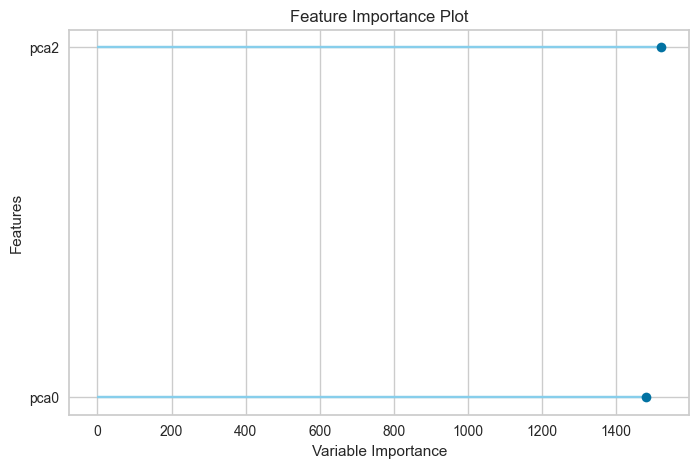

In [17]:
plot_model(lgbm, plot='feature')

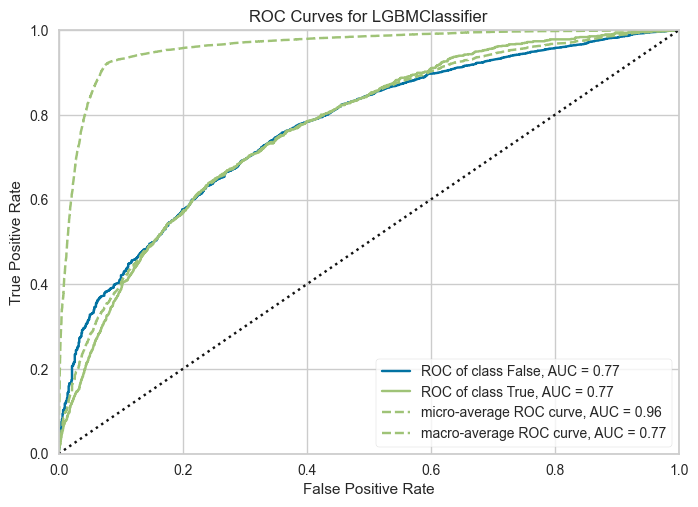

In [18]:
plot_model(lgbm, plot='auc')

In [19]:
save_model(lgbm,'modelo_final')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['qtd_filhos', 'idade',
                                              'tempo_emprego',
                                              'qt_pessoas_residencia', 'renda'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty_features=False,
                                                               missing_values=nan,
                                                               strategy='mean'))),
                 ('categorical_imputer',
                  TransformerWra...
                  LGBMClassifier(boosting_type='gbdt', class_weight=None,
            

In [20]:
model_saved = load_model('modelo_final')

Transformation Pipeline and Model Successfully Loaded
